## Impact of the 2014 FIFA World Cup on Host States in Brazil

This notebook investigates the impact of hosting the 2014 FIFA World Cup on Brazil's states. The analysis focuses on key economic and demographic outcomes using state-level data. Below are the key aspects of the notebook:

- **Objective**:  
  - Explore the economic and demographic impacts of the 2014 FIFA World Cup at the state level.  
  - Examine whether hosting the World Cup delivered measurable benefits or harms to host states.  

- **Methods Used**:  
  - **Difference-in-Differences (DiD)**: Estimates the changes in key outcomes by comparing trends in host states to non-host states before and after the World Cup.  
  - **Synthetic Control Methods (SCM)**: Constructs a synthetic version of each host state using non-host states with similar trends before the world cup to estimate what might have occurred without hosting.  

- **Key Variables**:  
  - Population growth.  
  - Economic development metrics (e.g., GDP, employment rates).  
  <!-- - Socio-economic indicators (e.g., infrastructure spending, tourism).   -->

- **Purpose**:  
  - Quantify the causal effects of hosting the World Cup.  
  - Assess the trade-offs between the benefits of hosting and the associated financial burden.  

<!-- - **Contribution**:  
  - Provides insights into the long-term impacts of mega-events on regional economies.  
  - Informs debates on whether hosting international sporting events justifies the investment.   -->


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
population_df = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/population_data.xlsx')
population_df.head()

,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ambos,0,BR,Brasil,3423475,3347313,3274356,3212295,3163041,3123546,...,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344
1,Ambos,0,BR,Brasil,3450022,3406966,3332612,3261091,3200484,3152623,...,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770
2,Ambos,0,BR,Brasil,3461038,3444450,3401900,3327924,3256791,3196543,...,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366
3,Ambos,0,BR,Brasil,3469109,3458052,3441638,3399284,3325501,3254582,...,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309
4,Ambos,0,BR,Brasil,3477903,3466901,3455987,3439662,3397467,3323811,...,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203


Population Data

In [3]:
# Define the range of years for analysis
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023, 2024]

# List of Brazilian states for filtering the data
states = [
    "Acre", "Alagoas", "Amapá", "Amazonas", "Bahia", "Ceará",
    "Distrito Federal", "Espírito Santo", "Goiás", "Maranhão",
    "Mato Grosso", "Mato Grosso do Sul", "Minas Gerais", "Paraná",
    "Paraíba", "Pará", "Pernambuco", "Piauí", "Rio Grande do Norte",
    "Rio Grande do Sul", "Rio de Janeiro", "Rondônia", "Roraima",
    "Santa Catarina", "Sergipe", "São Paulo", "Tocantins"
]

# Group population data by 'LOCAL' (state) and sum across the specified years
population_df = population_df.groupby('LOCAL', as_index=False)[years].sum()

# Filter the dataset to include only states
population_df = population_df[population_df['LOCAL'].isin(states)]

# Calculate percentage growth in population over time for each state
# Drop the 'LOCAL' column temporarily for percentage change calculations
population_growth_df = population_df.drop('LOCAL', axis=1)

# Calculate percentage change (growth rate) across years and multiply by 100 to get percentages
population_growth_df = population_growth_df.pct_change(axis=1) * 100

# Reinsert the 'STATE' column for easier reference after calculations
population_growth_df.insert(0, "STATE", population_df['LOCAL'])

# Remove the year 2000 since percentage growth cannot be calculated for the first year
population_growth_df.drop(2000, axis=1, inplace=True)

# Reshape the DataFrame from wide to long format for better analysis and visualization
population_growth_long_df = population_growth_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='Population_growth')
population_growth_long_df['YEAR'] = population_growth_long_df['YEAR'].astype(int)

population_growth_long_df.head()

,STATE,YEAR,Population_growth
0,Acre,2001,3.064908
1,Alagoas,2001,1.247077
2,Amapá,2001,4.333029
3,Amazonas,2001,2.477657
4,Bahia,2001,0.901883


State level GDP

In [4]:
gdp = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/GDP.xlsx')
gdp = gdp.rename(columns={"Unnamed: 0": "STATE"})

# Reshape the GDP DataFrame from wide to long format for better analysis and visualization
gdp_long_df = gdp.melt(id_vars=['STATE'], var_name='YEAR', value_name='GDP')
gdp_long_df['YEAR'] = gdp_long_df['YEAR'].astype(int)

gdp_long_df.head()

,STATE,YEAR,GDP
0,Rondônia,2002,7467.629889
1,Acre,2002,2971.301278
2,Amazonas,2002,22093.338008
3,Roraima,2002,2392.032670
4,Pará,2002,26482.158869


In [5]:

print(population_growth_long_df.shape)
print(gdp_long_df.shape)

(648, 3)
(567, 3)


In [6]:
print("\nMissing Values per Column:")
missing_values = population_growth_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

In [7]:
print("\nMissing Values per Column:")
missing_values = gdp_long_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

Industry Level Data

In [8]:
industry_level_data = pd.read_csv('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/gdp_by_industry.csv')


# Create a mapping dictionary to translate industry codes to readable names
industry_code_mapping = {
    513: 'Agriculture',                
    517: 'Industry',                 
    6575: 'Services',                 
    516: 'Construction',             
    548: 'Manufacturing',             
    546: 'Mining and Quarrying',      
    547: 'Electricity and Gas Supply' 
}

# Map the "Variável (Código)" column to the industry names using the mapping dictionary
industry_level_data['Industry'] = industry_level_data["Variável (Código)"].map(industry_code_mapping)

# Drop unnecessary columns to clean the dataset and focus on relevant data
industry_level_data.drop([
    'Nível Territorial (Código)',   
    'Nível Territorial',           
    'Unidade de Medida (Código)',  
    'Unidade de Medida',            
    'Unidade da Federação (Código)',
    'Ano (Código)',                 
    'Variável (Código)',           
    'Variável'                     
], axis=1, inplace=True)

# Create a dictionary to translate remaining column names into English
translation_dict_columns = {
    "Valor": "GDP",                 
    "Unidade da Federação": "STATE",
    "Ano": "YEAR"                   
}

# Rename the columns using the translation dictionary
industry_level_data.rename(columns=translation_dict_columns, inplace=True)

# Display the first few rows of the cleaned and translated dataset
industry_level_data.head()

,GDP,STATE,YEAR,Industry
0,284337.00,Acre,2002,Agriculture
1,355041.00,Acre,2002,Industry
2,1071069.00,Acre,2002,Services
3,10.37,Acre,2002,Construction
4,2.09,Acre,2002,Manufacturing


In [9]:
industry_level_data['Industry'].unique()

array(['Agriculture', 'Industry', 'Services', 'Construction',
       'Manufacturing', 'Mining and Quarrying',
       'Electricity and Gas Supply'], dtype=object)

In [10]:
# Create separate DataFrames for each industry by filtering the "Industry" column.
agrigulture_df = industry_level_data[industry_level_data['Industry'] == 'Agriculture']         
industry_df = industry_level_data[industry_level_data['Industry'] == 'Industry']              
services_df = industry_level_data[industry_level_data['Industry'] == 'Services']             
construction_df = industry_level_data[industry_level_data['Industry'] == 'Construction']      
manufacturing_df = industry_level_data[industry_level_data['Industry'] == 'Manufacturing']   
mining_df = industry_level_data[industry_level_data['Industry'] == 'Mining and Quarrying']   
electricity_gas_df = industry_level_data[industry_level_data['Industry'] == 'Electricity and Gas Supply'] 

print(agrigulture_df.shape)
print(industry_df.shape)
print(services_df.shape)
print(construction_df.shape)
print(manufacturing_df.shape)
print(mining_df.shape)
print(electricity_gas_df.shape)


(540, 4)
(540, 4)
(540, 4)
(540, 4)
(540, 4)
(540, 4)
(540, 4)


Emissions Data

In [48]:
emissions = pd.read_excel('/Users/muhammadmuhdhar/Desktop/Repo/WorldCupHostCities_Impact/data/CO2emmissions.xlsx')

# Rename the column "Estado" to "STATE" for consistency and easier understanding
emissions.rename(columns={"Estado": "STATE"}, inplace=True)

# Define a list of years for which data will be analyzed
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 
         2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 
         2020, 2021, 2022, 2023]

# Group the emissions data by "STATE" and sum the values for each year
emissions_df = emissions.groupby('STATE', as_index=False)[years].sum()

# Reshape the emissions DataFrame from wide format to long format
# This makes it easier for time-series analysis and visualization
emissions_long_df = emissions_df.melt(id_vars=['STATE'], var_name='YEAR', value_name='EMISSIONS')

# Convert the "YEAR" column to integers for consistency in data types
emissions_long_df['YEAR'] = emissions_long_df['YEAR'].astype(int)

emissions_long_df.head()

,STATE,YEAR,EMISSIONS
0,Acre,2001,1.903451e+08
1,Alagoas,2001,4.801885e+07
2,Amapá,2001,-3.509315e+07
3,Amazonas,2001,-5.323357e+08
4,Bahia,2001,5.672076e+08


In [49]:
emissions_long_df.shape

(644, 3)

## Difference-in-Differences (DiD) Analysis

### Objective
The Difference-in-Differences (DiD) analysis aims to evaluate the causal impact of hosting the 2014 FIFA World Cup on key outcomes, such as GDP growth, by comparing trends in host states (treatment group) and non-host states (control group) before and after the event. 

### Methodology
1. **Groups**:
   - **Treatment Group**: States that hosted the World Cup matches (e.g., São Paulo, Rio de Janeiro, Amazonas).
   - **Control Group**: States that did not host any matches, serving as a baseline for comparison.

2. **Time Periods**:
   - **Pre-Treatment Period**: Years before 2014.
   - **Post-Treatment Period**: Years after 2014, including and beyond the treatment year.

3. **Key Variables**:
   - **Dependent Variable**: `Population Growth (%)`, `GDP` – the year-over-year percentage change in GDP.
   - **Independent Variables**:
     - `post_treatment`: A binary indicator (1 for years after 2014, 0 otherwise).
     - `treatment_group`: A binary indicator (1 for host states, 0 otherwise).
     - Interaction Term (`post_treatment * treatment_group`): Captures the differential effect of the World Cup on host states in the post-treatment period.

In [13]:
host_states = [
    "São Paulo","Rio de Janeiro","Amazonas","Distrito Federal",
    "Bahia","Ceará","Pernambuco","Rio Grande do Sul",
    "Paraná","Rio Grande do Norte","Mato Grosso","Minas Gerais"    
]

non_host_states = [
    "Acre","Alagoas","Amapá",           
    "Maranhão","Mato Grosso do Sul","Espírito Santo",  
    "Goiás","Paraíba","Pará","Piauí",           
    "Rondônia","Roraima","Santa Catarina",  
    "Sergipe","Tocantins"        
]

In [14]:
# Define the treatment year as a Pandas Period object with annual frequency
# This represents the year when the World Cup took place
world_cup_treatment = pd.Period("2014", freq="Y")

# Convert the 'YEAR' column in the DataFrame to a Pandas PeriodIndex with annual frequency
# Ensures that the 'YEAR' column is treated as a time-based index, useful for comparisons
population_growth_long_df['Year'] = pd.PeriodIndex(population_growth_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' indicating whether each year is after the treatment year
# Assigns 1 if the year is after 2014, and 0 otherwise
population_growth_long_df['post_treatment'] = (population_growth_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether each state is a host state
# Assigns 1 for host states and 0 for non-host states
population_growth_long_df['treatment_group'] = (population_growth_long_df['STATE'].isin(host_states)).astype(int)

population_growth_long_df.sample(10)


,STATE,YEAR,Population_growth,Year,post_treatment,treatment_group
282,Minas Gerais,2011,0.478751,2011,0,1
112,Bahia,2005,0.739972,2005,0,1
273,Amazonas,2011,1.709537,2011,0,1
175,Paraná,2007,0.888993,2007,0,1
116,Goiás,2005,1.911617,2005,0,0
400,Roraima,2015,2.653058,2015,1,0
277,Espírito Santo,2011,0.966110,2011,0,0
359,Goiás,2014,1.457472,2014,0,0
436,Bahia,2017,0.355309,2017,1,1
230,Paraíba,2009,0.767676,2009,0,0


In [15]:
formula = 'Population_growth ~ post_treatment + treatment_group + post_treatment*treatment_group'

model = smf.ols(formula, data=population_growth_long_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Population_growth   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     53.04
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           1.20e-30
Time:                        12:01:21   Log-Likelihood:                -657.92
No. Observations:                 648   AIC:                             1324.
Df Residuals:                     644   BIC:                             1342.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [16]:
# Convert the 'YEAR' column into a Pandas PeriodIndex with an annual frequency
# This ensures the 'YEAR' column is treated as time-based data, enabling proper time comparisons
gdp_long_df['Year'] = pd.PeriodIndex(gdp_long_df['YEAR'].astype(str), freq='Y')

# Create a new column 'post_treatment' to indicate whether the year is after the treatment year (2014)
# Assigns 1 if the year is after 2014 (post-treatment), and 0 otherwise
gdp_long_df['post_treatment'] = (gdp_long_df['Year'] > world_cup_treatment).astype(int)

# Create a new column 'treatment_group' to indicate whether the state is in the treatment group (host states)
# Assigns 1 for host states and 0 for non-host states
gdp_long_df['treatment_group'] = (gdp_long_df['STATE'].isin(host_states)).astype(int)

# Ensure the 'treatment_group' column is correctly assigned (this duplicates the assignment above, likely redundant)
# Assigns 1 for states in the host states list, and 0 for all others
gdp_long_df['treatment_group'] = (gdp_long_df['STATE'].isin(host_states)).astype(int)


In [17]:
gdpformula = 'GDP ~ post_treatment + treatment_group + post_treatment*treatment_group'

gdpmodel = smf.ols(gdpformula, data=gdp_long_df)
results = gdpmodel.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     59.49
Date:                Sun, 01 Dec 2024   Prob (F-statistic):           2.04e-33
Time:                        12:01:21   Log-Likelihood:                -7960.0
No. Observations:                 567   AIC:                         1.593e+04
Df Residuals:                     563   BIC:                         1.595e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Synthetic Control Analysis: Economic Impacts of the 2014 FIFA World Cup

### Purpose
The analysis employs Synthetic Control Methods (SCM) to evaluate the economic impact of hosting the 2014 FIFA World Cup. By constructing a synthetic benchmark, it estimates how economic indicators like GDP growth might have evolved in the absence of the event.

#### Approach

**1. Treatment and Control Setup**
- **Treated Unit**: A specific host state, such as Rio de Janeiro or São Paulo, selected for analysis.
- **Synthetic Unit**: A weighted combination of non-host states that closely resemble the treated state during the pre-treatment period.

**2. Time Frames**
- **Baseline Period**: The years leading up to 2014, used to calibrate the synthetic model.
- **Impact Period**: The years following 2014, analyzed to identify deviations between actual outcomes and the synthetic benchmark.

**3. Outcome Measures**
- **Primary**: 
  - Real GDP per Capita Growth (annual percentage change).
- **Secondary**:
  - Population Growth
  <!-- - Public Infrastructure Spending.
  - Tourism Revenue Growth. -->
  
**4. Matching Variables**
- Economic trends before 2014:
  - GDP per capita.
  <!-- - Infrastructure investment.
  - Unemployment rates.
  - Average wage growth. -->
- Demographic factors:
  - Population size.
  <!-- - Urbanization rates. -->

**5. Assessment of Impacts**
- **Outcome Comparison**: A line chart showing the trends in GDP growth (or other outcomes) for the treated state versus its synthetic control.
- **Difference Plot**: A graph highlighting the gap between the treated state and the synthetic control during the impact period.

#### Key Assumptions
1. Non-host states can serve as valid counterfactuals for host states.
2. The synthetic control accurately captures unobserved factors affecting the treated state in the absence of the World Cup.
3. The economic effects of the World Cup are concentrated in host states, with minimal spillover to non-host states.

In [18]:
years_before_worldcup = [2001,2002,2003,2004,2005,2006,
                         2007,2008,2009,2010,2011,2012,2013]

# Filter the DataFrame for rows within the specified years
population_before_worldcup = population_growth_long_df[
    population_growth_long_df['YEAR'].isin(years_before_worldcup)
]

population_before_worldcup.head()

,STATE,YEAR,Population_growth,Year,post_treatment,treatment_group
0,Acre,2001,3.064908,2001,0,0
1,Alagoas,2001,1.247077,2001,0,0
2,Amapá,2001,4.333029,2001,0,0
3,Amazonas,2001,2.477657,2001,0,1
4,Bahia,2001,0.901883,2001,0,1


In [19]:

# Separate host and non-host states
host_states_population_before_worldcup = population_before_worldcup[population_before_worldcup['STATE'].isin(host_states)]
non_host_states_population_before_worldcup = population_before_worldcup[population_before_worldcup['STATE'].isin(non_host_states)]

print(host_states_population_before_worldcup.shape)
print(non_host_states_population_before_worldcup.shape)

(156, 6)
(195, 6)


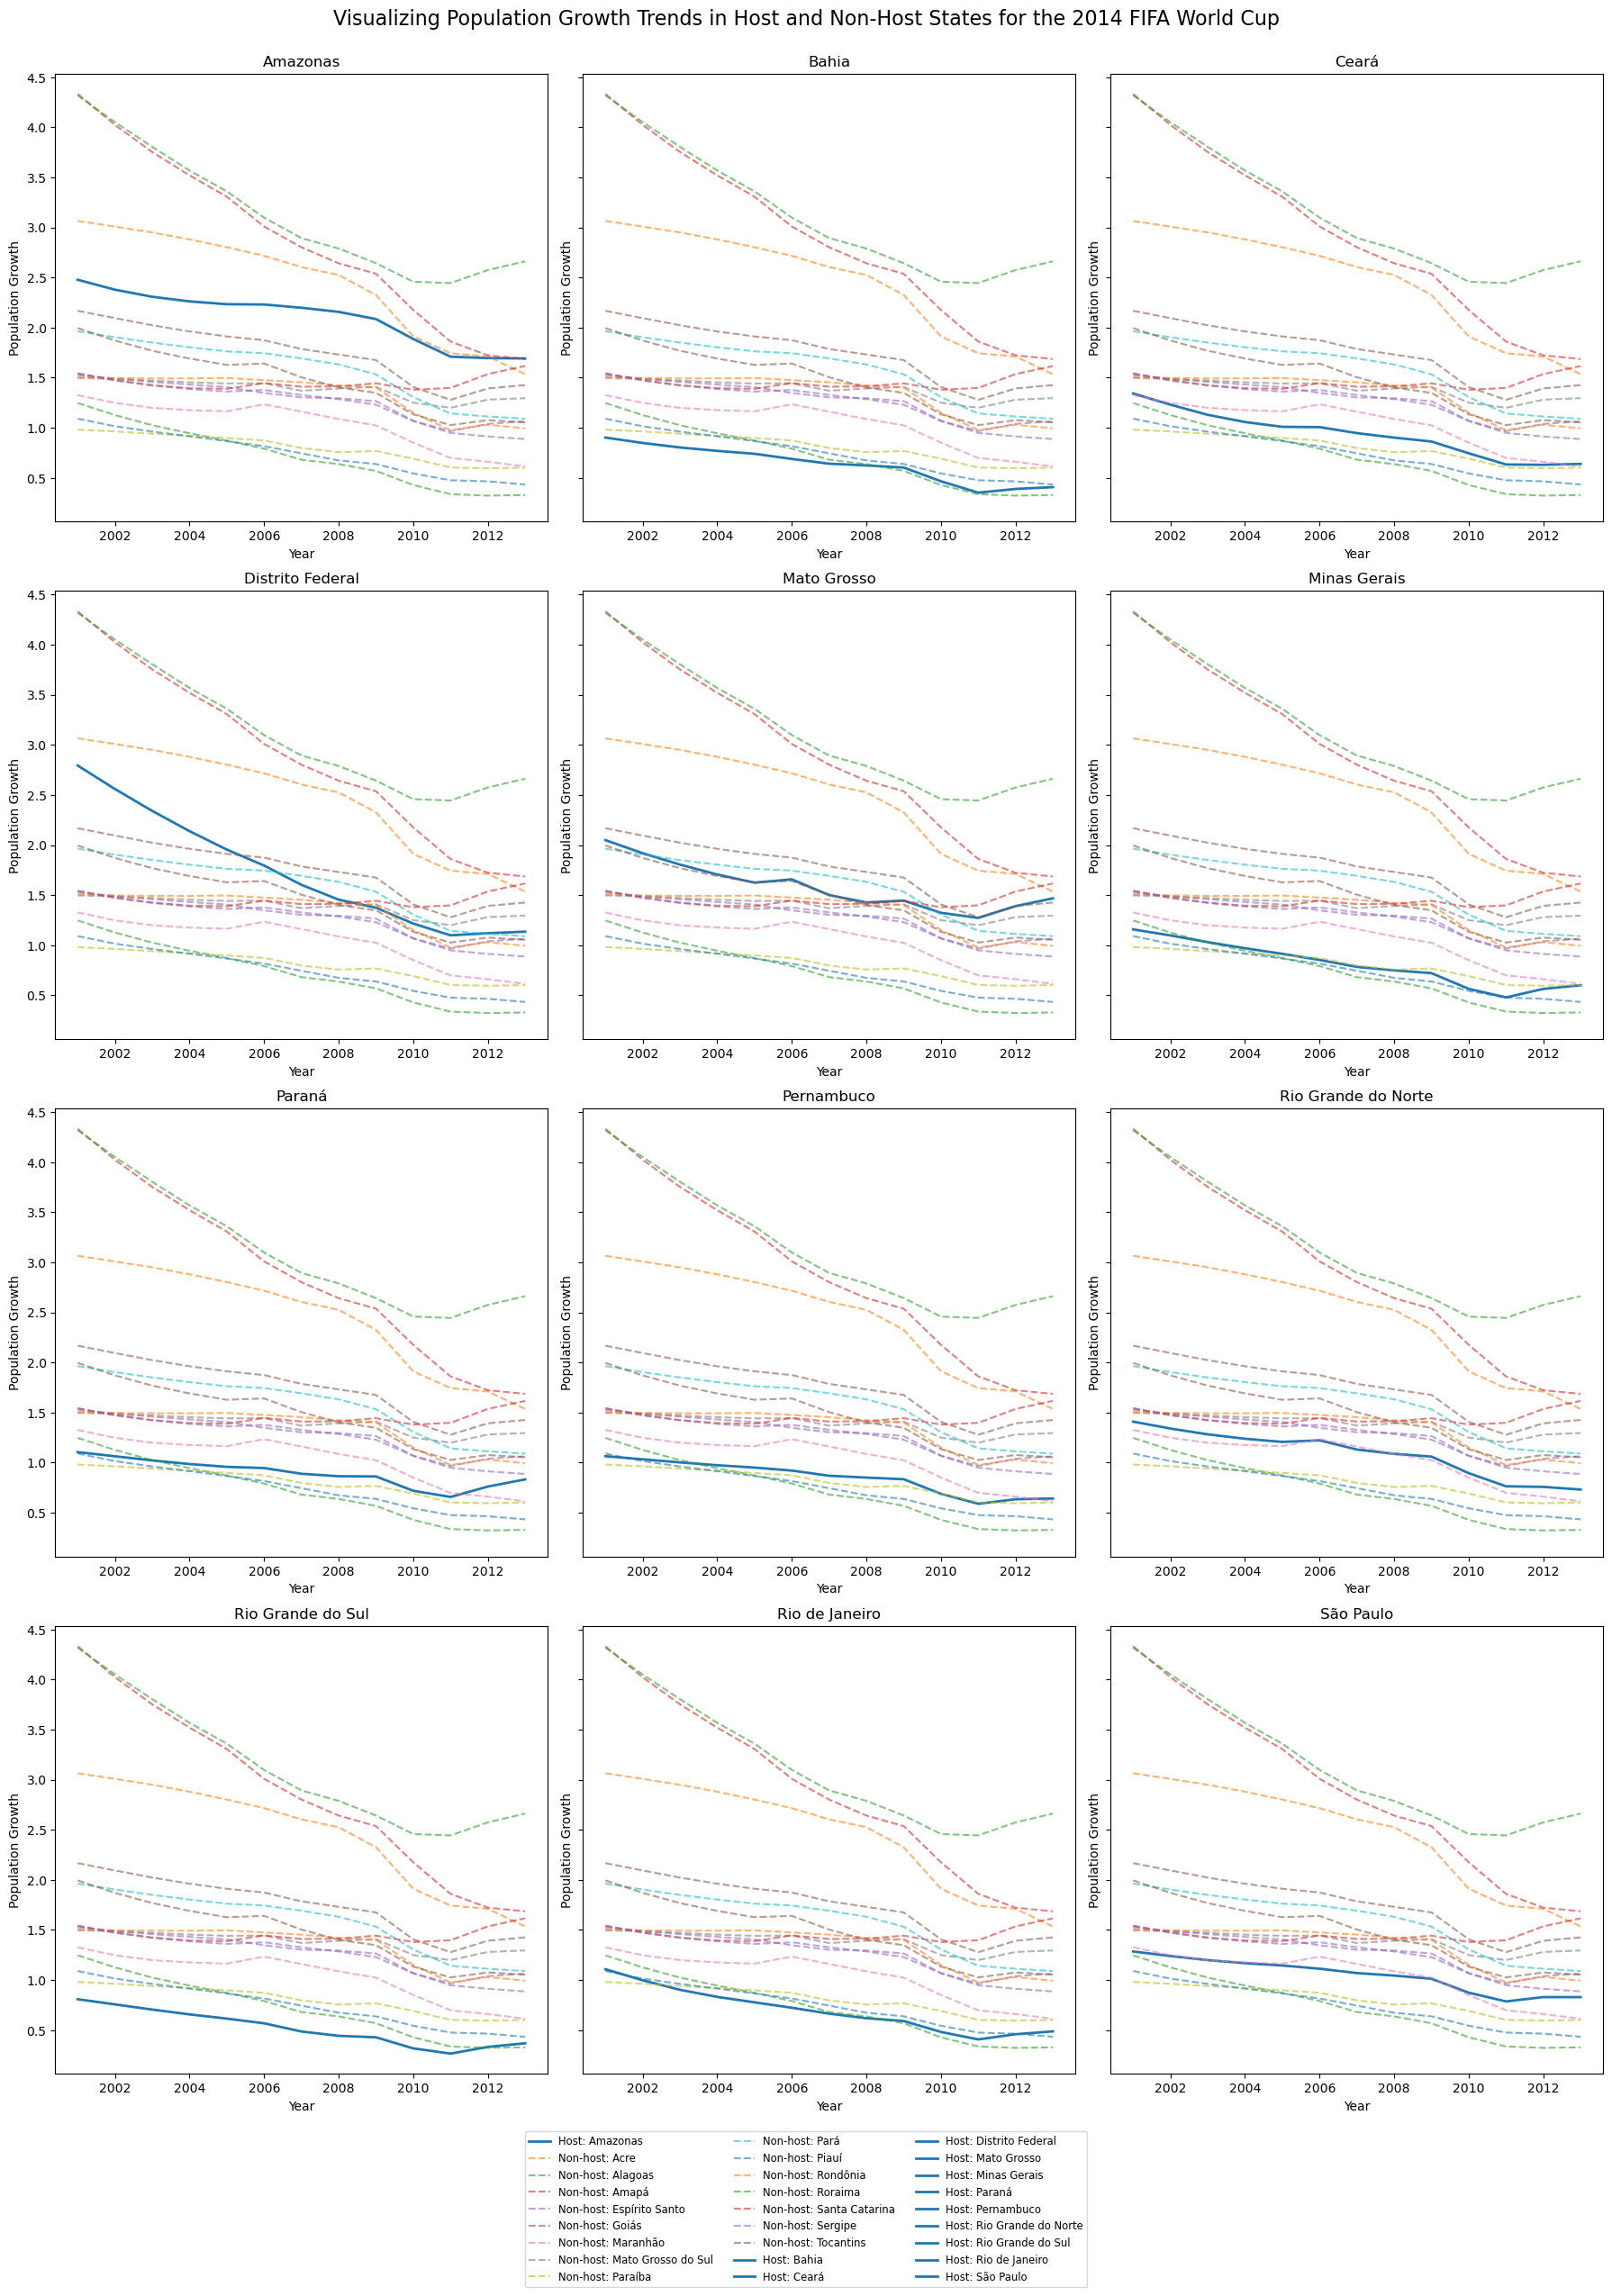

In [20]:

num_host_states = host_states_population_before_worldcup['STATE'].nunique()

# Calculate rows dynamically
rows = (num_host_states + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows), sharey=True)

# Flatten axes to a 1D array for consistent indexing
axes = np.array(axes).flatten()

# Keep track of handles and labels for a combined legend
handles = []
labels = []

for id, state in enumerate(host_states_population_before_worldcup['STATE'].unique()):
    ax = axes[id]
    
    # Filter data for the specific host state
    host_data = host_states_population_before_worldcup[host_states_population_before_worldcup['STATE'] == state]
    
    # Plot host state population growth
    host_line, = ax.plot(host_data['YEAR'], host_data['Population_growth'], 
                         linewidth=2, label=f'Host: {state}')
    
    # Add to legend tracking (only add once per type)
    if not any(lbl == host_line.get_label() for lbl in labels):
        handles.append(host_line)
        labels.append(host_line.get_label())
    
    # Plot non-host states for comparison
    for non_host_state in non_host_states_population_before_worldcup['STATE'].unique():
        non_host_data = non_host_states_population_before_worldcup[non_host_states_population_before_worldcup['STATE'] == non_host_state]
        non_host_line, = ax.plot(non_host_data['YEAR'], non_host_data['Population_growth'], 
                                 linestyle='--', alpha=0.6, label=f'Non-host: {non_host_state}')
        
        # Add to legend tracking (only add once per type)
        if not any(lbl == non_host_line.get_label() for lbl in labels):
            handles.append(non_host_line)
            labels.append(non_host_line.get_label())
    
    # Set title and labels for clarity
    ax.set_title(state)
    ax.set_xlabel("Year")
    ax.set_ylabel("Population Growth")
    
# Hide unused subplots
for id in range(len(host_states_population_before_worldcup['STATE'].unique()), len(axes)):
    axes[id].axis('off')

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize="small")

fig.suptitle("Visualizing Population Growth Trends in Host and Non-Host States for the 2014 FIFA World Cup", fontsize=16)

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()


In [21]:
# Filter the DataFrame for rows within the specified years
gdp_before_worldcup = gdp_long_df[
    gdp_long_df['YEAR'].isin(years_before_worldcup)
]

gdp_before_worldcup.head()

,STATE,YEAR,GDP,Year,post_treatment,treatment_group
0,Rondônia,2002,7467.629889,2002,0,0
1,Acre,2002,2971.301278,2002,0,0
2,Amazonas,2002,22093.338008,2002,0,1
3,Roraima,2002,2392.032670,2002,0,0
4,Pará,2002,26482.158869,2002,0,0


In [22]:
# Separate host and non-host states
host_states_gdp_before_worldcup = gdp_before_worldcup[gdp_before_worldcup['STATE'].isin(host_states)]
non_host_gdp_before_worldcup = gdp_before_worldcup[gdp_before_worldcup['STATE'].isin(non_host_states)]

print(host_states_gdp_before_worldcup.shape)
print(non_host_gdp_before_worldcup.shape)

(132, 6)
(180, 6)


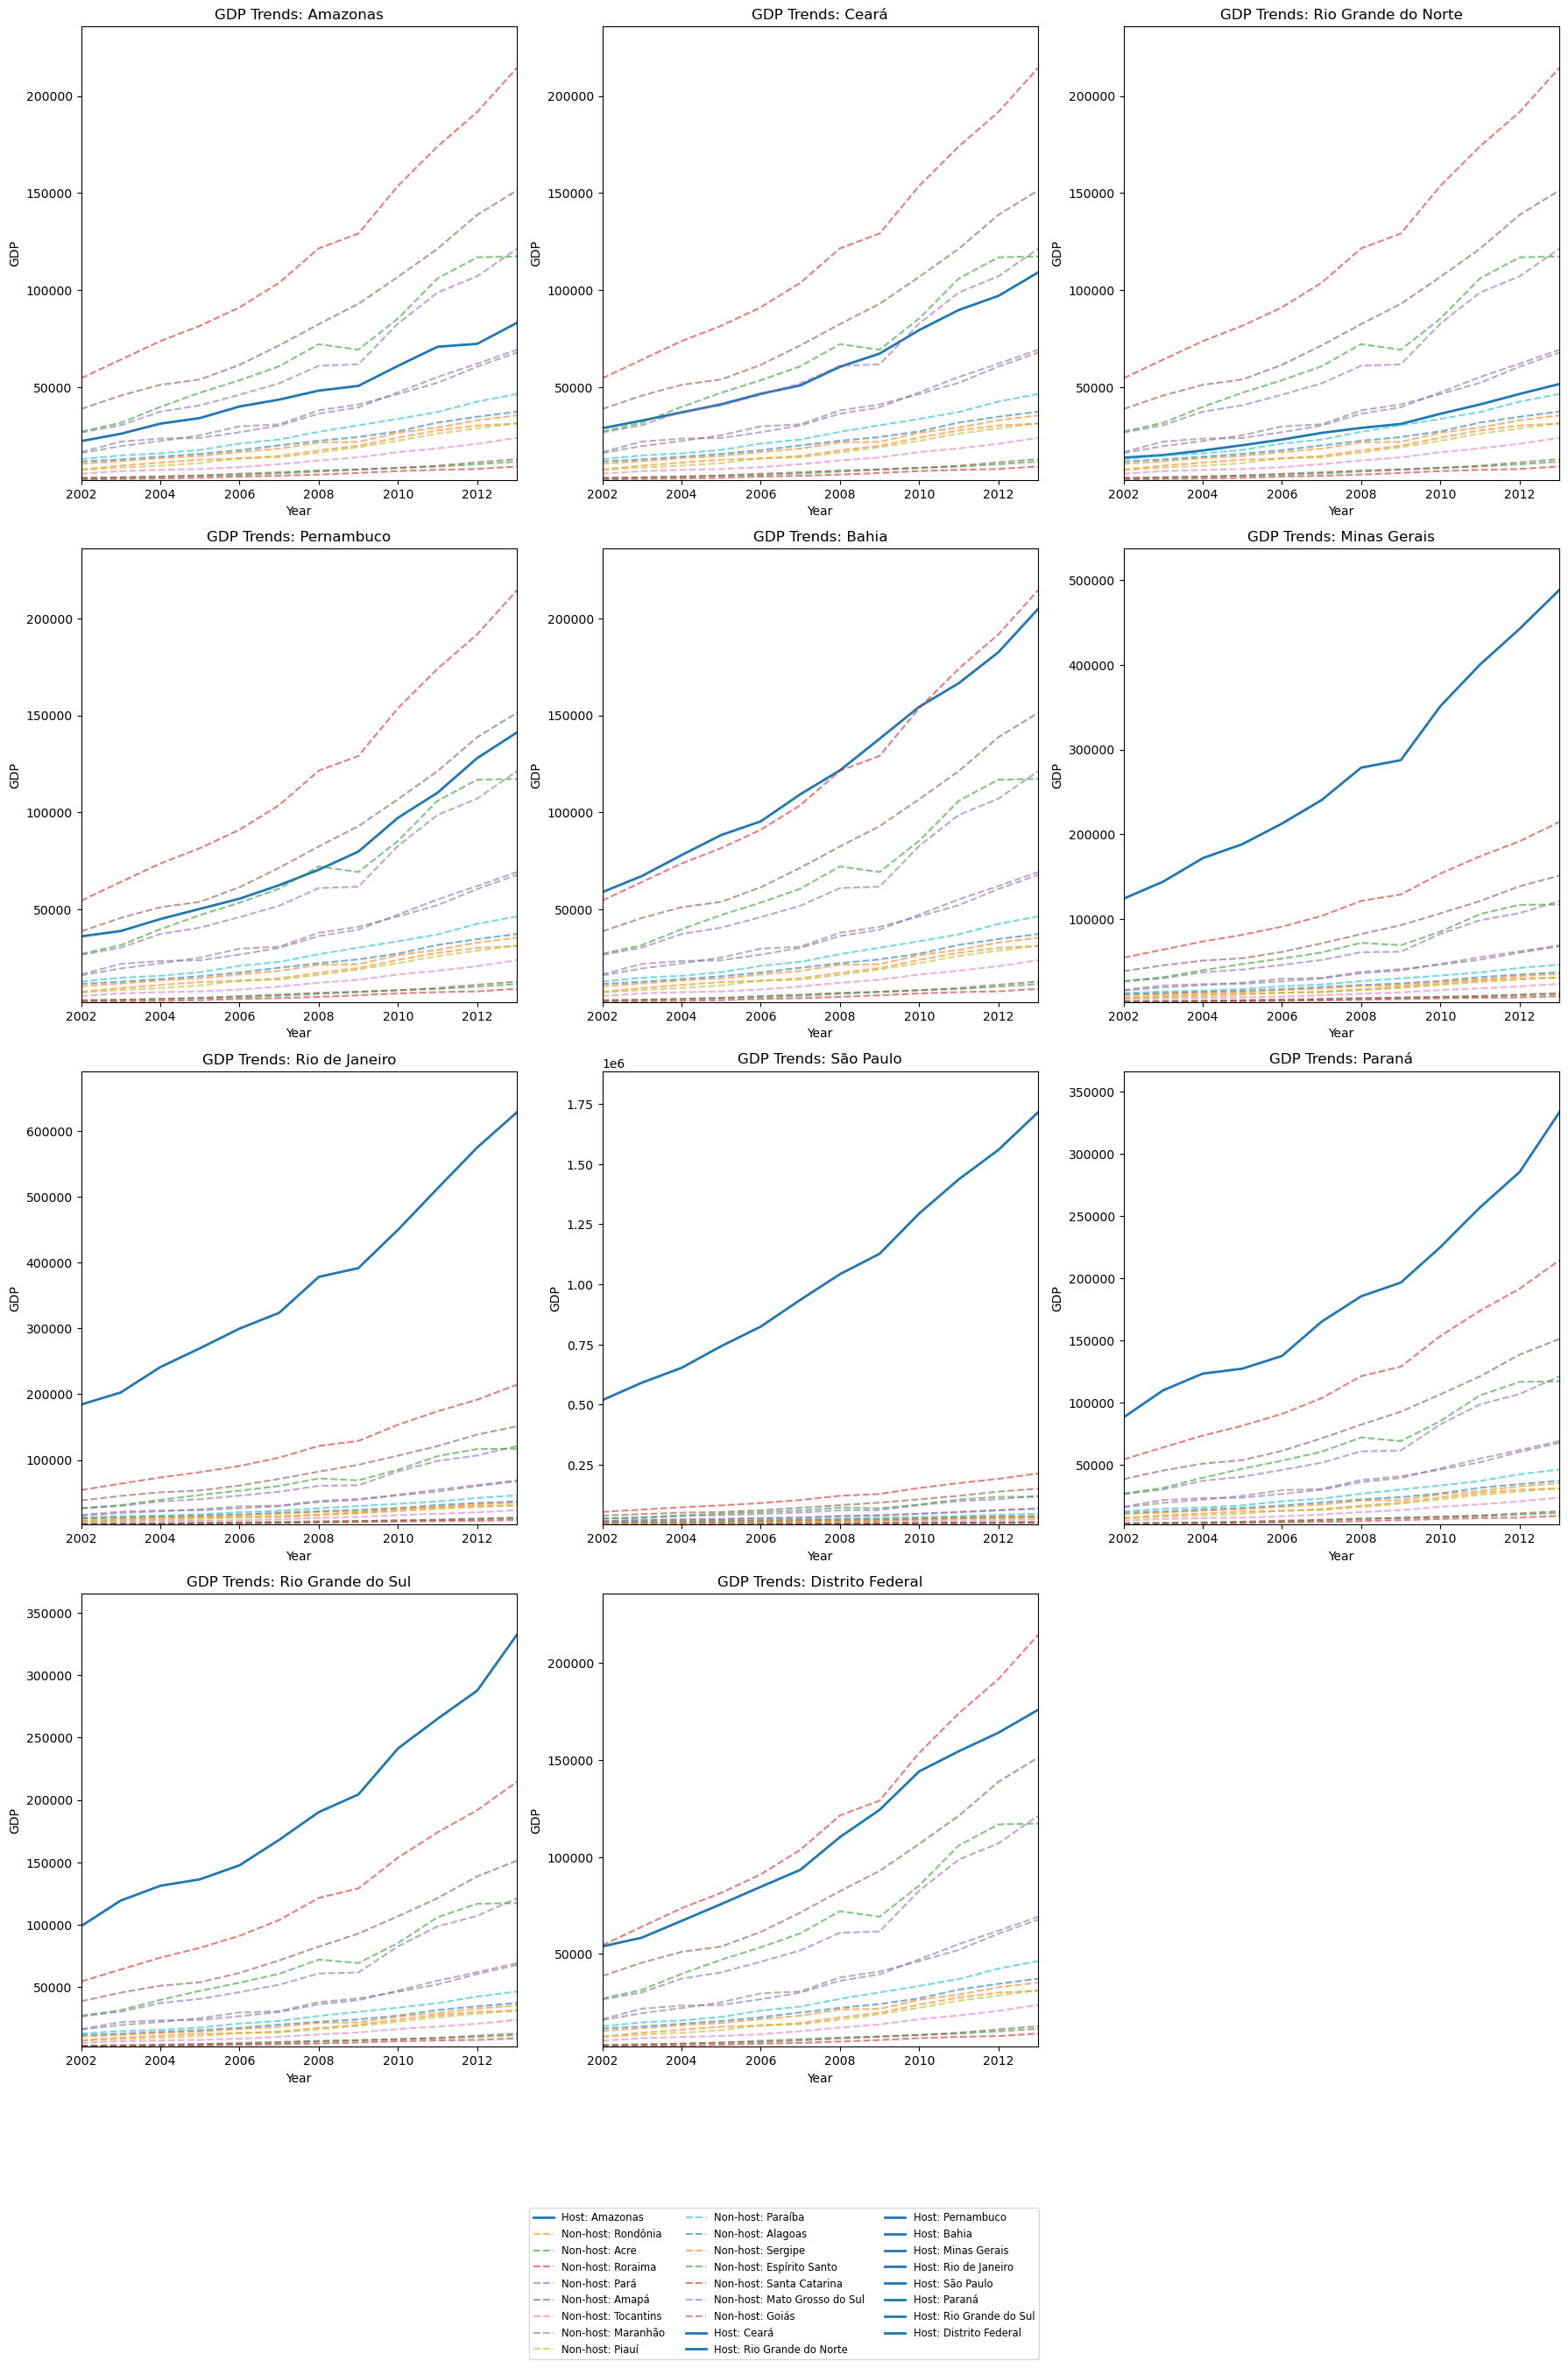

In [23]:
# Calculate the number of unique host states
num_host_states = host_states_gdp_before_worldcup['STATE'].nunique()

# Dynamically calculate the number of rows for subplots
rows = (num_host_states + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows), sharey=False)  # Turn off shared y-axis for flexibility

# Flatten axes to a 1D array for consistent indexing
axes = np.array(axes).flatten()

# Keep track of handles and labels for a combined legend
handles = []
labels = []

for idx, state in enumerate(host_states_gdp_before_worldcup['STATE'].unique()):
    ax = axes[idx]
    
    # Filter data for the specific host state
    host_data = host_states_gdp_before_worldcup[host_states_gdp_before_worldcup['STATE'] == state]
    
    # Plot host state GDP trends
    host_line, = ax.plot(host_data['YEAR'], host_data['GDP'], 
                         linewidth=2, label=f'Host: {state}')
    
    # Add to legend tracking (only add once per label)
    if host_line.get_label() not in labels:
        handles.append(host_line)
        labels.append(host_line.get_label())
    
    # Plot non-host states for comparison
    for non_host_state in non_host_gdp_before_worldcup['STATE'].unique():
        non_host_data = non_host_gdp_before_worldcup[non_host_gdp_before_worldcup['STATE'] == non_host_state]
        non_host_line, = ax.plot(non_host_data['YEAR'], non_host_data['GDP'], 
                                 linestyle='--', alpha=0.6, label=f'Non-host: {non_host_state}')
        
        # Add to legend tracking (only add once per label)
        if non_host_line.get_label() not in labels:
            handles.append(non_host_line)
            labels.append(non_host_line.get_label())
    
    # Dynamically adjust axis limits
    y_min = min(host_data['GDP'].min(), non_host_gdp_before_worldcup['GDP'].min())
    y_max = max(host_data['GDP'].max(), non_host_gdp_before_worldcup['GDP'].max())
    ax.set_ylim(y_min * 0.9, y_max * 1.1)  # Add 10% padding above and below
    
    x_min = min(host_data['YEAR'].min(), non_host_gdp_before_worldcup['YEAR'].min())
    x_max = max(host_data['YEAR'].max(), non_host_gdp_before_worldcup['YEAR'].max())
    ax.set_xlim(x_min, x_max)  # Set x-axis limits
    
    # Set title and labels for clarity
    ax.set_title(f"GDP Trends: {state}")
    ax.set_xlabel("Year")
    ax.set_ylabel("GDP")

# Hide unused subplots
for idx in range(len(host_states_gdp_before_worldcup['STATE'].unique()), len(axes)):
    axes[idx].axis('off')

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize="small")

plt.tight_layout()
plt.show()